In [1]:
import tensorflow as tf
import boto3, os
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

2025-11-30 17:03:23.008584: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 17:03:23.009211: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 17:03:23.067298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 17:03:24.528729: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Training Parameters:

In [2]:
EPOCHS = 600
BATCHSIZE = 32
LR = 8e-5
TRAIN_PERCENTAGE = 0.8

**Idea:**

inputs:


_ list np.array of index for the weather

        0 = snow or rain
        1 = heavy cloudy/ Windy
        2= cloudy
        3 = blue sky

_ list np.array of temperature in °C

_ Traffic time in minutes

In [3]:
# Architecture:
def DNN():
    input_id_skatepark = Input(shape = (1,), name= 'id_skateparks')
    input_weather  = Input(shape=(1,), name='weather_input')
    input_temp     = Input(shape=(1,), name='weather_temp')
    #intput_traffic = Input(shape=(15,), name='weather_traffic')

    # Embedding to create vectors for index:
    emb_skatepark = Embedding(input_dim=15 + 1, output_dim=5)(input_id_skatepark)
    emb_skatepark = tf.keras.layers.Flatten()(emb_skatepark)
    
    emb_weather = Embedding(input_dim=4 + 1, output_dim=2)(input_weather)
    emb_weather = tf.keras.layers.Flatten()(emb_weather)

    concat_features = Concatenate()([
        emb_skatepark,
        emb_weather,
        input_temp,
        #intput_traffic
    ])


    x = Dense(64, activation='relu')(concat_features)
    x = Dense(32, activation='relu')(x)

    output = Dense(1, activation = "sigmoid", name='preference_score')(x)

    model = keras.Model(
        inputs = [input_id_skatepark, input_weather, input_temp],#, intput_traffic ],
        outputs = output
    )
    optimizer_adam = tf.keras.optimizers.Adam(learning_rate=LR) 
    model.compile(
        optimizer=optimizer_adam,
        loss='binary_crossentropy',
        metrics=['mae']
    )
    model.summary()    
    return model

model = DNN()


2025-11-30 17:03:25.834713: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ id_skateparks       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 5)      │         80 │ id_skateparks[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 2)      │         10 │ weather_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_temp        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8)         │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ weather_temp[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        576 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preference_score    │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,779 (10.86 KB)

 Trainable params: 2,779 (10.86 KB)

 Non-trainable params: 0 (0.00 B)

## Generator:

Get access to the S3 bucket:

In [4]:
s3 = boto3.client(
    "s3",
    endpoint_url=os.getenv("S3_ENDPOINT"),
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name="us-east-1"
)

In [5]:
BUCKET_NAME = "skatedata"   
FILE_KEY = "clean_skatepark_dataset.csv"  

obj = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)
df = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8')))

print(df.head())

  spot_name  index spot  weather  temperature  satisfaction
0  Ahuntsic           0        0         -6.3             0
1  Ahuntsic           0        0         23.7             0
2  VanHorne           1        0          4.0             0
3  VanHorne           1        0         24.3             1
4    Verdun           2        0          7.2             0


In [6]:
import numpy as np
import random
from tensorflow.keras.utils import Sequence

class SkateSpotGenerator(Sequence):
    def __init__(self, df, batchsize=32):
        self.df = df
        self.df_size = df.shape[0]
        self.n_skateparks = df["index spot"].nunique()
        self.batchsize = batchsize

        # Indices des groupes complets seulement
        self.indexes = list(range(0, self.df_size - self.n_skateparks + 1, self.n_skateparks))
        self.on_epoch_end()  # shuffle initial

    def __len__(self):
        return int(np.ceil(len(self.indexes) / self.batchsize))

    def __getitem__(self, idx):
        batch_start = idx * self.batchsize
        batch_end = batch_start + self.batchsize
        batch_indices = self.indexes[batch_start:batch_end]

        id_batch = []
        weather_batch = []
        temp_batch = []
        traffic_batch = []
        satisfaction_batch = []

        for current_idx in batch_indices:
            row = self.df.iloc[current_idx]
            id_batch.append(row["index spot"])
            weather_batch.append(row["weather"])
            temp_batch.append(row["temperature"])
            #traffic.append(row["traffic_time"])
            satisfaction_batch.append(row["satisfaction"])

        return (
            (
                np.array(id_batch),
                np.array(weather_batch),
                np.array(temp_batch),
                #np.array(traffic_batch)
            ),
            np.array(satisfaction_batch)
        )

    def on_epoch_end(self):
        random.shuffle(self.indexes)


In [7]:
df_train = df.sample(frac=TRAIN_PERCENTAGE, random_state=42)  
df_val   = df.drop(df_train.index)             

train_generator = SkateSpotGenerator(df = df_train, batchsize = BATCHSIZE)
val_generator   = SkateSpotGenerator(df = df_val, batchsize = BATCHSIZE)

In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/600


/usr/local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5517 - mae: 0.3248 - val_loss: 0.6639 - val_mae: 0.3517
Epoch 2/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5440 - mae: 0.3237 - val_loss: 0.6528 - val_mae: 0.3501
Epoch 3/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5369 - mae: 0.3229 - val_loss: 0.6413 - val_mae: 0.3489
Epoch 4/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5297 - mae: 0.3226 - val_loss: 0.6296 - val_mae: 0.3479
Epoch 5/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5231 - mae: 0.3221 - val_loss: 0.6187 - val_mae: 0.3471
Epoch 6/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5162 - mae: 0.3222 - val_loss: 0.6102 - val_mae: 0.3457
Epoch 7/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5115 - mae: 0.3215 - val_loss: 0.6015 - val_mae: 0.3449
Epoch 8/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5076 - mae: 0.3222 - val_loss: 0.5925 - val_mae: 0.3444
Epoch 9/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5019 - mae: 0.3217 - val

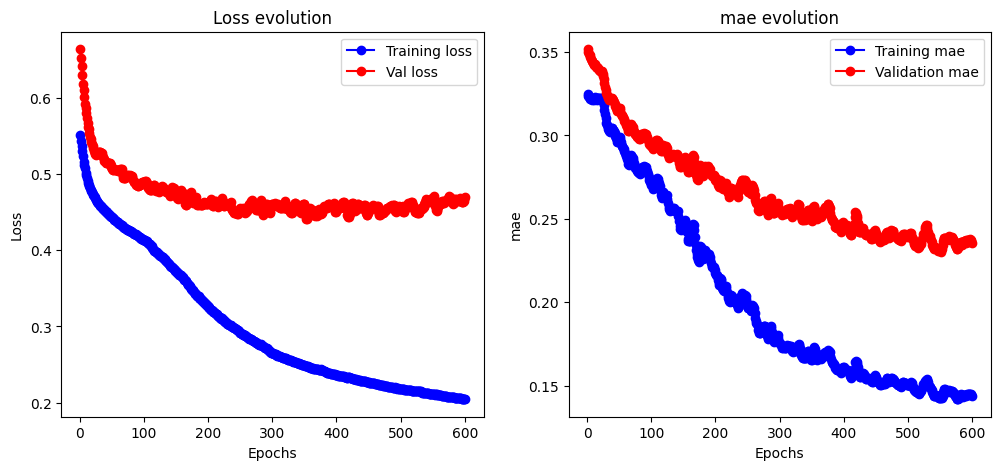

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']

mae = history.history.get('mae')
val_mae = history.history.get('val_mae')

epochs = range(1, EPOCHS + 1)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo-', label = "Training loss")
plt.plot(epochs, val_loss, 'ro-', label = "Val loss")

plt.title("Loss evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, mae, 'bo-', label='Training mae')
plt.plot(epochs, val_mae, 'ro-', label="Validation mae")
plt.title( "mae evolution")
plt.xlabel('Epochs')
plt.ylabel("mae")
plt.legend()
plt.show()

## Testing:

In [10]:

skateparks_list = [
    "Ahuntsic"         , # 0
    "VanHorne"         , # 1
    "Verdun"           , # 2
    "Lasalle"          , # 3
    "Préfontaine"      , # 4
    "Boucherville"     , # 5
    "Taz"              , # 6
    "Spin"             , # 7
    "Saint Jérome"     , # 8
    "Saint Sauveur"    , # 9
    "Assomption"       , # 10
    "Benny"            , # 11
    "Dorval"           , # 12
    "Magog"            , # 13
    "Berthierville"      # 14
]

# Weather: 
# Rain or Snow  = 0
# Clouds + Wind = 1
# Clouds        = 2
# Blue sky      = 3

weather_dict = {
    0: "Rain or Snow",
    1: "Windy or heavily cloudy",
    2: "cloudy",
    3: "Blue sky"
}

for idx_weather, weather_name in weather_dict.items():
    print("\n\n\n=== Weather:", weather_name, "===")
    for idx_skatespot, skatespot in enumerate(skateparks_list):
        temp = random.uniform(-10, 10)
        result = model.predict([
            np.array([idx_skatespot]),   # index du skatepark
            np.array([idx_weather]),    # weather
            np.array([temp])          
        ])
        print(f"Temp = {temp}°C, Result for {skatespot} = {result[0][0] * 100} %")


        temp = random.uniform(15, 25)
        result = model.predict([
            np.array([idx_skatespot]),   # index du skatepark
            np.array([idx_weather]),# weather
            np.array([temp])
        ])
        print(f"Temp = {temp}°C, Result for {skatespot} = {result[0][0] * 100} %\n\n")






=== Weather: Rain or Snow ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Temp = 6.2024568275045695°C, Result for Ahuntsic = 0.06800635904073715 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Temp = 19.45654893958735°C, Result for Ahuntsic = 0.3695833086967468 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Temp = 0.6342202035597673°C, Result for VanHorne = 3.8763179779052734 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Temp = 23.34750640346946°C, Result for VanHorne = 31.044218063354492 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Temp = -5.369718821045706°C, Result for Verdun = 0.005590805783867836 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Temp = 18.107512990763954°C, Result for Verdun = 0.7218920588493347 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Temp = 1.596769541125111°C, Result for Lasalle = 2.4748661518096924 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Temp = 24.63756162871077°C, Result for Lasalle = 26.585418701171875 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Temp = -7.705354837059264°C, Result for Préfonta